# LSTM Neural Network Model for COVID-19 Data

Employing an LSTM (Long Short Term Memory) Neural Network to forecast COVID-19 data as a time series. 

The neural network predicts confirmed cases, deaths, and recoveries related to COVID-19 for today based on the information from the past few days.

The features, as well as the number of past days the network trains on, can all be adjusted.

https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
from datetime import datetime
from math import sqrt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

Get the data (both the competition data and the ESRI data of ICU and hospitalizations)

In [2]:
df = pd.read_csv('Data/train.csv')
esri_df = pd.read_csv('Data/Provincial_Daily_Totals.csv')

### Clean the Data

First clean the competition data

In [3]:
# Change date to datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Convert dates to the day of the year
df['Day_of_Year'] = df['Date'].apply(lambda x: x.dayofyear)

# Day of the week
df["Day_of_Week"] = df["Date"].apply(lambda x: x.dayofweek)

# Drop some of the columns
df.drop(columns=['Id', 'Lat', 'Long', 'Testing_Info'], inplace=True)

# Drop data for repatriated Canadians repatriated data
df.drop(df[df['Province'] == 'Repatriated'].index, inplace=True)

# Fill N/A values to 0
df = df.fillna(0)

# Set index to Date
df.set_index('Date', inplace=True)

Plot the data for all provinces

Text(0, 0.5, 'Number of Deaths')

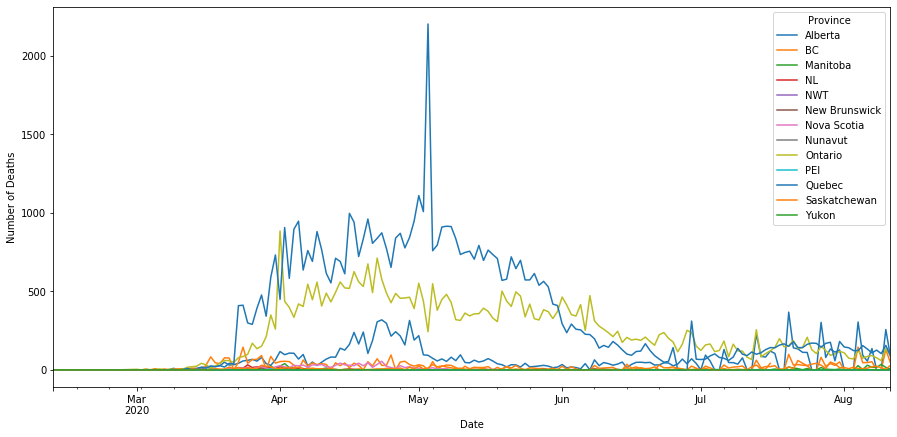

In [4]:
fig, ax = plt.subplots(figsize=(15,7))
df.groupby(['Date','Province']).mean()['# Confirmed_Cases'].unstack().plot(ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Deaths')

Clean the ESRI data

In [5]:
# Remove the data for Canada and Repatriated Canadians
esri_df.drop(esri_df[esri_df['Abbreviation'].isin(['CA', 'RC'])].index, inplace=True)

# Change the province names to be consistent with the Competition dataset
esri_df.loc[esri_df['Province'] == 'ALBERTA', ['Province']] = 'Alberta'
esri_df.loc[esri_df['Province'] == 'BRITISH COLUMBIA', ['Province']] = 'BC'
esri_df.loc[esri_df['Province'] == 'MANITOBA', ['Province']] = 'Manitoba'
esri_df.loc[esri_df['Province'] == 'NEW BRUNSWICK', ['Province']] = 'New Brunswick'
esri_df.loc[esri_df['Province'] == 'NEWFOUNDLAND AND LABRADOR', ['Province']] = 'NL'
esri_df.loc[esri_df['Province'] == 'NORTHWEST TERRITORIES', ['Province']] = 'NWT'
esri_df.loc[esri_df['Province'] == 'NOVA SCOTIA', ['Province']] = 'Nova Scotia'
esri_df.loc[esri_df['Province'] == 'NUNAVUT', ['Province']] = 'Nunavut'
esri_df.loc[esri_df['Province'] == 'ONTARIO', ['Province']] = 'Ontario'
esri_df.loc[esri_df['Province'] == 'PRINCE EDWARD ISLAND', ['Province']] = 'PEI'
esri_df.loc[esri_df['Province'] == 'QUEBEC', ['Province']] = 'Quebec'
esri_df.loc[esri_df['Province'] == 'SASKATCHEWAN', ['Province']] = 'Saskatchewan'
esri_df.loc[esri_df['Province'] == 'YUKON', ['Province']] = 'Yukon'

# Fill the N/A values
esri_df = esri_df.fillna(0)

# Change the Date to the Day of the Year
esri_df['Date'] = pd.to_datetime(esri_df['SummaryDate'])
esri_df['Day_of_Year'] = esri_df['Date'].apply(lambda x: x.dayofyear)

# Drop some of the unecessary columns
esri_df.drop(columns=['OBJECTID', 'SummaryDate', 'Date', 'DailyTested', 'DailyTotals', 'DailyRecovered', 'DailyDeaths', 'Abbreviation', 'TotalCases', 'TotalRecovered', 'TotalDeaths', 'TotalTested'], inplace=True)

### Prepare the Data

Merge the ICU and Hospitalization data into the competition data

In [6]:
df = df.merge(esri_df, on=['Province', 'Day_of_Year'])

Get the data for Ontario

In [7]:
df = df[df['Province'] == 'Ontario']
df.drop(columns=['Province', 'Population'], inplace=True)
df.set_index('Day_of_Year', inplace=True)

Get the number of features and sort the column names by index

In [8]:
num_features = df.shape[1]
column_indices = {name: i for i, name in enumerate(df.columns)}

Split into train, validation, and test sets (70%, 20%, 10%)

In [9]:
n = df.shape[0]
train_df = df[0:round(n*0.7)]
valid_df = df[round(n*0.7):round(n*0.9)]
test_df = df[round(n*0.9):]

Normalize the data

In [10]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df-train_mean)/train_std
valid_df = (valid_df-train_mean)/train_std
test_df = (test_df-train_mean)/train_std

Visual the normalized data

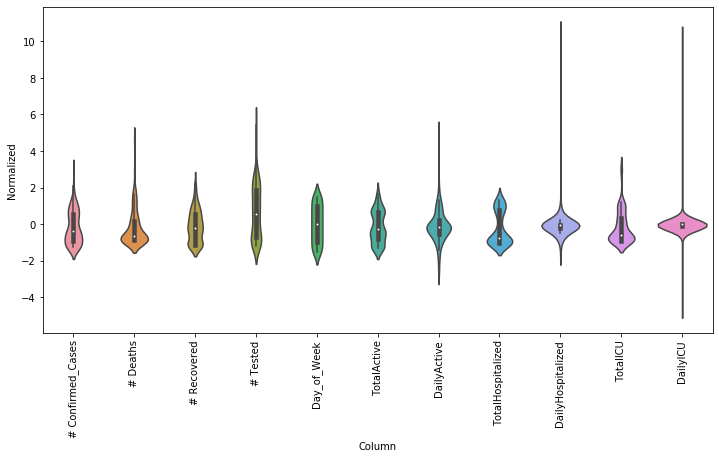

In [11]:
import seaborn as sns
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

### WindowGenerator Class

Create a class to represent time windows for training the neural networks.

All code in this section is from https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing

In [12]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, valid_df=valid_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.valid_df = valid_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

The function to split a time window into a window of features and a window of labels

In [13]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [14]:
# w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
#                      label_columns=['# Deaths'])
# w2

In [15]:
# # Stack three figures, each the length of the window, and each giving a slice of the data:
# example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
#                            np.array(train_df[50:50+w2.total_window_size]),
#                            np.array(train_df[100:100+w2.total_window_size])])


# example_inputs, example_labels = w2.split_window(example_window)

# print('All shapes are: (batch, time, features)')
# print(f'Window shape: {example_window.shape}')
# print(f'Inputs shape: {example_inputs.shape}')
# print(f'labels shape: {example_labels.shape}')

In [16]:
# w2.example = example_inputs, example_labels

Define a plot function for the windows

In [17]:
def plot(self, model=None, plot_col='# Deaths', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [days]')

WindowGenerator.plot = plot

In [18]:
# w2.plot()

Define a function to take a DataFrame and convert it into a tf.data.Dataset object of the
form (input_window, label_window) 

In [19]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=16,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

Add properties to the WindowGenerator objects to access the training, validation, and test sets

In [20]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.valid_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [21]:
# # Each element is an (inputs, label) pair
# w2.train.element_spec

In [22]:
# for example_inputs, example_labels in w2.train.take(1):
#   print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
#   print(f'Labels shape (batch, time, features): {example_labels.shape}')

## Create the Models

In [250]:
labels = ['# Deaths']

Create a single time-step window, using the results from yesterday to predict the results today

In [251]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=labels)

# Output the dimensions
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time-steps, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time-steps, features): {example_labels.shape}')

Inputs shape (batch, time-steps, features): (16, 1, 11)
Labels shape (batch, time-steps, features): (16, 1, 1)


Create dictionaries to store the performance measurements for the models

In [252]:
val_performance = {}
performance = {}

### 1) Baseline Model

Assume what happens today is what happened yesterday

In [298]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [299]:
# create the model using the single step window
baseline = Baseline(label_index=column_indices['# Deaths'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

# evaluate the baseline model on the validation and test sets
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

KeyError: ('# Confirmed_Cases', '# Deaths')

See the predictions over a 10 day period

In [255]:
wide_window = WindowGenerator(
    input_width=10, label_width=10, shift=1,
    label_columns=labels)
wide_window

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [ 1  2  3  4  5  6  7  8  9 10]
Label column name(s): ['# Deaths']

In [256]:
print('Input shape (batch, time-steps, features):', wide_window.example[0].shape)
print('Output shape (batch, time-steps, features):', baseline(wide_window.example[0]).shape)

Input shape (batch, time-steps, features): (16, 10, 11)
Output shape (batch, time-steps, features): (16, 10, 1)


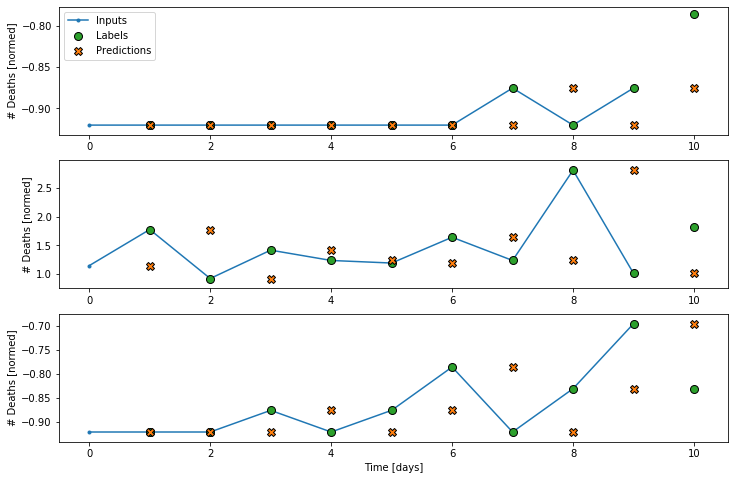

In [257]:
wide_window.plot(baseline)

### 2) Linear Model

In [258]:
linear_model = Sequential([
    Dense(units=1)
])

In [259]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (16, 1, 11)
Output shape: (16, 1, 1)


In [260]:
# Define a maximum of 50 epochs
MAX_EPOCHS = 50

# Define a function to compile and fit the models
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [261]:
history = compile_and_fit(linear_model, single_step_window)

val_performance['Linear'] = linear_model.evaluate(single_step_window.val)
performance['Linear'] = linear_model.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
8/8 [==============================] - 1s 53ms/step - loss: 1.7881 - mean_absolute_error: 1.0615 - val_loss: 3.4598 - val_mean_absolute_error: 1.7597
Epoch 2/50
8/8 [==============================] - 0s 24ms/step - loss: 1.8650 - mean_absolute_error: 1.0500 - val_loss: 3.4507 - val_mean_absolute_error: 1.7586
Epoch 3/50
8/8 [==============================] - 0s 40ms/step - loss: 1.7389 - mean_absolute_error: 1.0266 - val_loss: 3.4304 - val_mean_absolute_error: 1.7543
Epoch 4/50
8/8 [==============================] - 1s 83ms/step - loss: 1.5016 - mean_absolute_error: 0.9412 - val_loss: 3.4100 - val_mean_absolute_error: 1.7500
Epoch 5/50
8/8 [==============================] - 0s 27ms/step - loss: 1.3760 - mean_absolute_error: 0.8894 - val_loss: 3.3794 - val_mean_absolute_error: 1.7429
Epoch 6/50
8/8 [==============================] - 0s 28ms/step - loss: 1.2228 - mean_absolute_error: 0.8207 - val_loss: 3.3561 - val_mean_absolute_error: 1.7376
Epoch 7/50
8/8 [==================

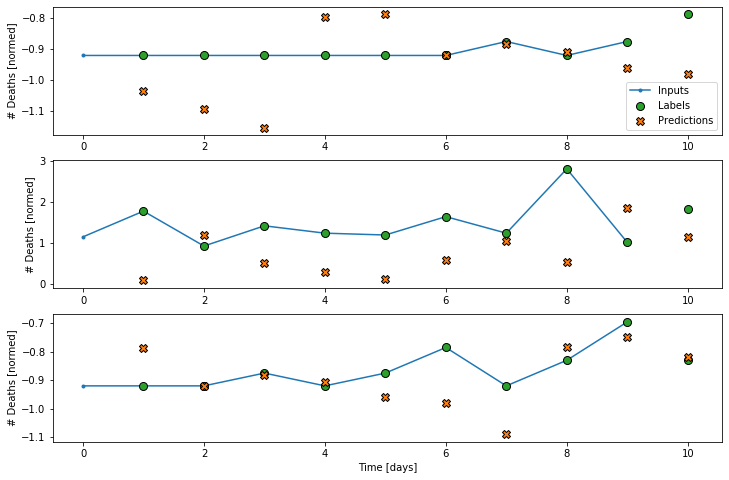

In [262]:
wide_window.plot(linear_model)

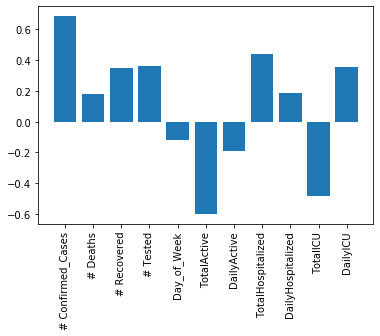

In [263]:
plt.bar(x = range(len(train_df.columns)),
        height=linear_model.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

### 3) Dense Model

In [264]:
dense_model = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(dense_model, single_step_window)

val_performance['Dense'] = dense_model.evaluate(single_step_window.val)
performance['Dense'] = dense_model.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
8/8 [==============================] - 2s 138ms/step - loss: 0.6687 - mean_absolute_error: 0.6255 - val_loss: 0.2229 - val_mean_absolute_error: 0.4081
Epoch 2/50
8/8 [==============================] - 0s 50ms/step - loss: 0.2488 - mean_absolute_error: 0.3331 - val_loss: 0.2235 - val_mean_absolute_error: 0.4063
Epoch 3/50
8/8 [==============================] - 0s 37ms/step - loss: 0.3281 - mean_absolute_error: 0.4124 - val_loss: 0.2009 - val_mean_absolute_error: 0.3857
Epoch 4/50
8/8 [==============================] - 0s 35ms/step - loss: 0.2000 - mean_absolute_error: 0.2957 - val_loss: 0.1560 - val_mean_absolute_error: 0.3324
Epoch 5/50
8/8 [==============================] - 0s 36ms/step - loss: 0.2378 - mean_absolute_error: 0.2947 - val_loss: 0.1055 - val_mean_absolute_error: 0.2620
Epoch 6/50
8/8 [==============================] - 0s 48ms/step - loss: 0.2131 - mean_absolute_error: 0.2746 - val_loss: 0.0816 - val_mean_absolute_error: 0.2322
Epoch 7/50
8/8 [=================

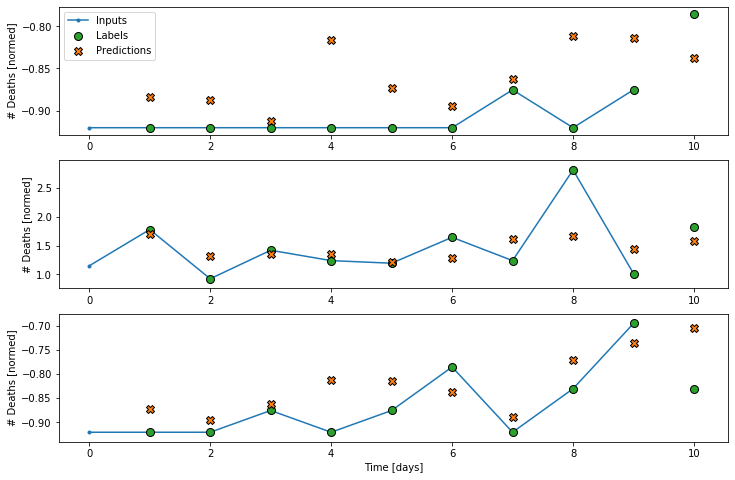

In [265]:
wide_window.plot(dense_model)

### 4) Multi-step Dense Model 

Use data from multiple steps backwards to predict the next step

In [266]:
# Use data from m days ago to predict the value on the m^th day
m = 10

conv_window = WindowGenerator(
    input_width=m,
    label_width=1,
    shift=1,
    label_columns=labels)

conv_window

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10]
Label column name(s): ['# Deaths']

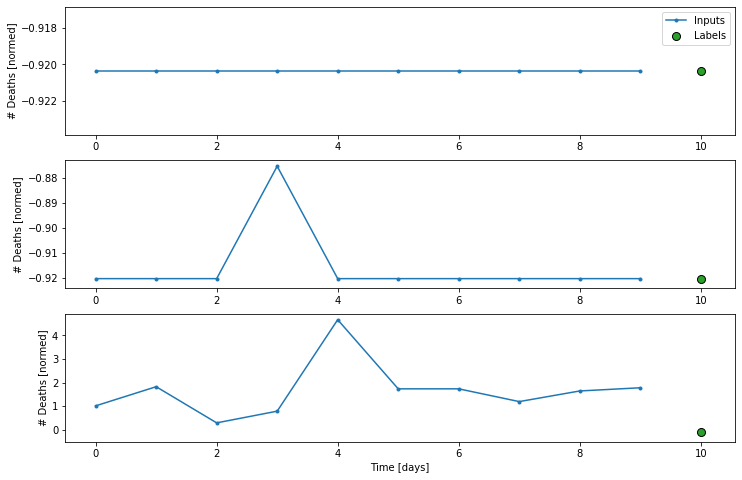

In [267]:
conv_window.plot()

In [268]:
multi_step_dense_model = Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    Dense(units=32, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [269]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense_model(conv_window.example[0]).shape)

Input shape: (16, 10, 11)
Output shape: (16, 1, 1)


In [270]:
history = compile_and_fit(multi_step_dense_model, conv_window)

val_performance['Multi step dense'] = multi_step_dense_model.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
8/8 [==============================] - 1s 44ms/step - loss: 1.2444 - mean_absolute_error: 0.8489 - val_loss: 0.1611 - val_mean_absolute_error: 0.3278
Epoch 2/50
8/8 [==============================] - 0s 21ms/step - loss: 0.3746 - mean_absolute_error: 0.3706 - val_loss: 0.1620 - val_mean_absolute_error: 0.3490
Epoch 3/50
8/8 [==============================] - 0s 35ms/step - loss: 0.4033 - mean_absolute_error: 0.4293 - val_loss: 0.1378 - val_mean_absolute_error: 0.3197
Epoch 4/50
8/8 [==============================] - 0s 41ms/step - loss: 0.4496 - mean_absolute_error: 0.4064 - val_loss: 0.1300 - val_mean_absolute_error: 0.2797
Epoch 5/50
8/8 [==============================] - 0s 28ms/step - loss: 0.3053 - mean_absolute_error: 0.3400 - val_loss: 0.1421 - val_mean_absolute_error: 0.2850
Epoch 6/50
2/2 [==============================] - 0s 6ms/step - loss: 0.1482 - mean_absolute_error: 0.2886


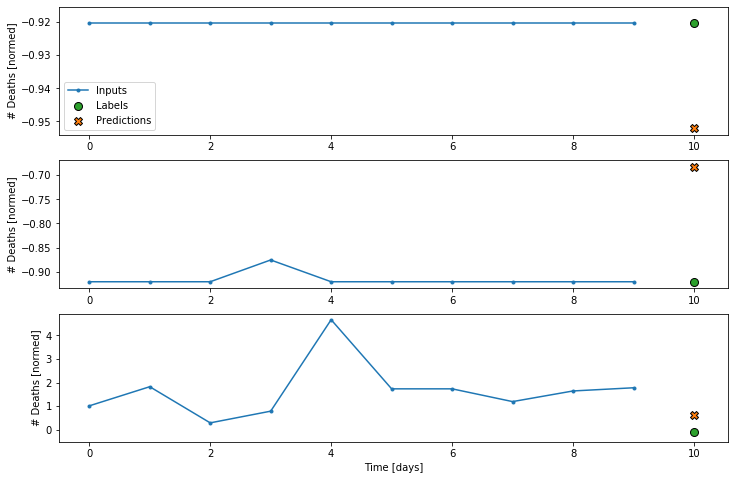

In [271]:
conv_window.plot(multi_step_dense_model)

### 5) Convolutional Neural Network

In [272]:
conv_model = Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(m,),
                           activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1),
])

In [273]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (16, 10, 11)
Output shape: (16, 1, 1)


In [274]:
history = compile_and_fit(conv_model, conv_window)

val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
8/8 [==============================] - 2s 90ms/step - loss: 1.5277 - mean_absolute_error: 0.9442 - val_loss: 0.3280 - val_mean_absolute_error: 0.5480
Epoch 2/50
8/8 [==============================] - 0s 25ms/step - loss: 0.6027 - mean_absolute_error: 0.4908 - val_loss: 0.2887 - val_mean_absolute_error: 0.5130
Epoch 3/50
8/8 [==============================] - 0s 33ms/step - loss: 0.3963 - mean_absolute_error: 0.4029 - val_loss: 0.2339 - val_mean_absolute_error: 0.4594
Epoch 4/50
8/8 [==============================] - 0s 34ms/step - loss: 0.3153 - mean_absolute_error: 0.3796 - val_loss: 0.2005 - val_mean_absolute_error: 0.4217
Epoch 5/50
8/8 [==============================] - 0s 44ms/step - loss: 0.3370 - mean_absolute_error: 0.3419 - val_loss: 0.1671 - val_mean_absolute_error: 0.3787
Epoch 6/50
8/8 [==============================] - 0s 22ms/step - loss: 0.3030 - mean_absolute_error: 0.3001 - val_loss: 0.1472 - val_mean_absolute_error: 0.3492
Epoch 7/50
8/8 [==================

In [275]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (16, 10, 11)
Labels shape: (16, 10, 1)
Output shape: (16, 1, 1)


To plot, we need the labels and the predictions to have the same length.
Therefore, build a WindowGenerator to produce wide windows with a few extra inpout time steps

In [276]:
LABEL_WIDTH = 10
INPUT_WIDTH = LABEL_WIDTH + (m - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=labels)
wide_conv_window

Total window size: 20
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Label indices: [10 11 12 13 14 15 16 17 18 19]
Label column name(s): ['# Deaths']

In [277]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (16, 19, 11)
Labels shape: (16, 10, 1)
Output shape: (16, 10, 1)


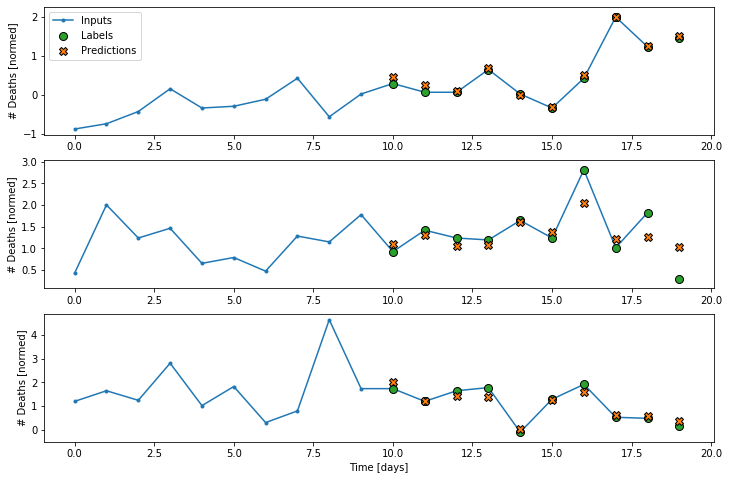

In [278]:
wide_conv_window.plot(conv_model)

### 6) Recurrent Neural Network (LSTM)

In [279]:
lstm_model = Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    LSTM(32),
#     LSTM(32, return_sequences=True),
#     LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    Dense(units=1)
])

In [280]:
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (16, 10, 11)
Labels shape: (16, 10, 1)
Output shape: (16, 1)


In [281]:
history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
8/8 [==============================] - 4s 214ms/step - loss: 0.9753 - mean_absolute_error: 0.7942 - val_loss: 0.6512 - val_mean_absolute_error: 0.7869
Epoch 2/50
8/8 [==============================] - 1s 95ms/step - loss: 0.5578 - mean_absolute_error: 0.5225 - val_loss: 0.4775 - val_mean_absolute_error: 0.6701
Epoch 3/50
8/8 [==============================] - 0s 31ms/step - loss: 0.3390 - mean_absolute_error: 0.3834 - val_loss: 0.2889 - val_mean_absolute_error: 0.5134
Epoch 4/50
8/8 [==============================] - 0s 23ms/step - loss: 0.3007 - mean_absolute_error: 0.3892 - val_loss: 0.1854 - val_mean_absolute_error: 0.4015
Epoch 5/50
8/8 [==============================] - 0s 36ms/step - loss: 0.3006 - mean_absolute_error: 0.3479 - val_loss: 0.1159 - val_mean_absolute_error: 0.3041
Epoch 6/50
8/8 [==============================] - 0s 44ms/step - loss: 0.2987 - mean_absolute_error: 0.3436 - val_loss: 0.0767 - val_mean_absolute_error: 0.2400
Epoch 7/50
8/8 [=================

In [282]:
# wide_window.plot(lstm_model)

Performance and comparison of the models

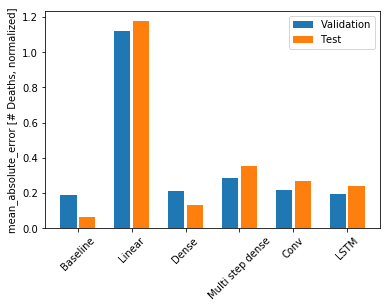

In [283]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [# Deaths, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [284]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0661
Linear      : 1.1766
Dense       : 0.1318
Multi step dense: 0.3555
Conv        : 0.2693
LSTM        : 0.2412


### 8) Multi Output Models

In [322]:
wide_window_2 = WindowGenerator(
    input_width=10, label_width=10, shift=1)

In [323]:
baseline_2 = Baseline()
baseline_2.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [324]:
val_performance_2 = {}
performance_2 = {}
val_performance_2['Baseline'] = baseline_2.evaluate(wide_window_2.val)
performance_2['Baseline'] = baseline_2.evaluate(wide_window_2.test, verbose=0)

2/2 [==============================] - 0s 38ms/step - loss: 0.4843 - mean_absolute_error: 0.3230


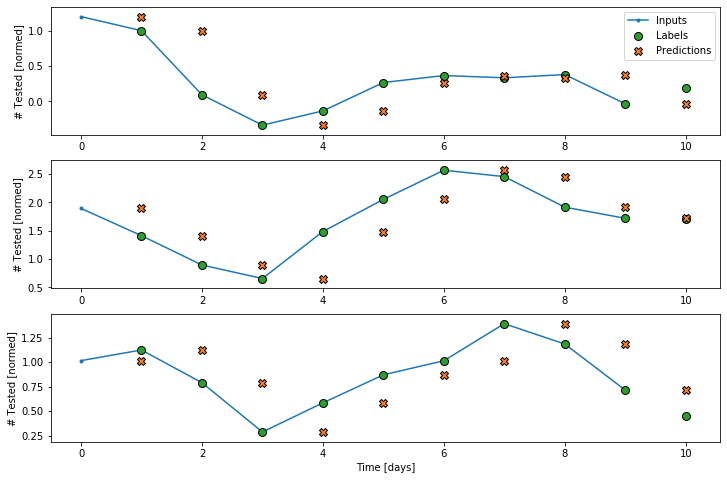

In [330]:
wide_window_2.plot(baseline_2, plot_col='# Tested')

In [332]:
lstm_model = Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window_2)

val_performance['LSTM'] = lstm_model.evaluate( wide_window_2.val)
performance['LSTM'] = lstm_model.evaluate( wide_window_2.test, verbose=0)

Epoch 1/50
8/8 [==============================] - 5s 183ms/step - loss: 1.0456 - mean_absolute_error: 0.7922 - val_loss: 0.8567 - val_mean_absolute_error: 0.7434
Epoch 2/50
8/8 [==============================] - 0s 39ms/step - loss: 0.9621 - mean_absolute_error: 0.7213 - val_loss: 0.8500 - val_mean_absolute_error: 0.7439
Epoch 3/50
8/8 [==============================] - 0s 59ms/step - loss: 0.8530 - mean_absolute_error: 0.6625 - val_loss: 0.8470 - val_mean_absolute_error: 0.7458
Epoch 4/50
8/8 [==============================] - 0s 40ms/step - loss: 0.7089 - mean_absolute_error: 0.5928 - val_loss: 0.8345 - val_mean_absolute_error: 0.7413
Epoch 5/50
8/8 [==============================] - 0s 35ms/step - loss: 0.6700 - mean_absolute_error: 0.5482 - val_loss: 0.8234 - val_mean_absolute_error: 0.7362
Epoch 6/50
8/8 [==============================] - 0s 51ms/step - loss: 0.5904 - mean_absolute_error: 0.5044 - val_loss: 0.8081 - val_mean_absolute_error: 0.7278
Epoch 7/50
8/8 [=================

8/8 [==============================] - 0s 36ms/step - loss: 0.2343 - mean_absolute_error: 0.2585 - val_loss: 0.4804 - val_mean_absolute_error: 0.4764
Epoch 47/50
8/8 [==============================] - 0s 29ms/step - loss: 0.2169 - mean_absolute_error: 0.2610 - val_loss: 0.4794 - val_mean_absolute_error: 0.4751
Epoch 48/50
8/8 [==============================] - 1s 78ms/step - loss: 0.2457 - mean_absolute_error: 0.2628 - val_loss: 0.4807 - val_mean_absolute_error: 0.4756
Epoch 49/50
2/2 [==============================] - 0s 14ms/step - loss: 0.4810 - mean_absolute_error: 0.4753


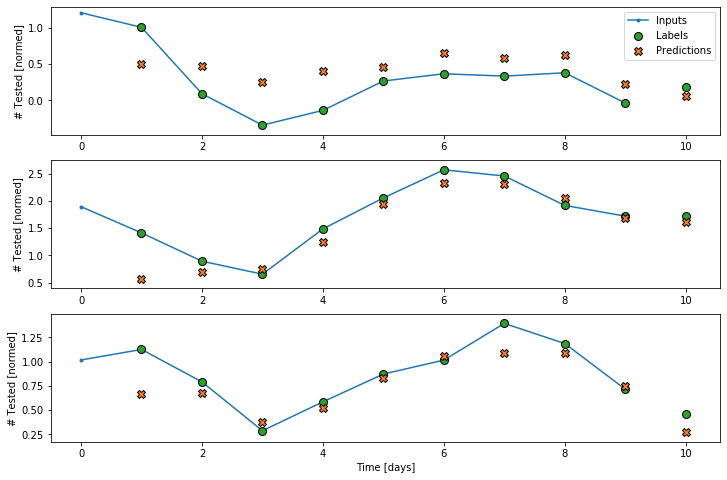

In [335]:
wide_window_2.plot(lstm_model, plot_col='# Tested')

### 7) Multi-step Models

The models before only predict one or several features just one unit into the future.

This will treat the case of predicting several units into the future (multiple timestep predictions).

Two approaches:

1) Single shot predictions where the entire time series is predicted at once.

2) Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

Here, all the models will predict all the features across all output time steps.

Create the Window object for the multi-step output

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): None

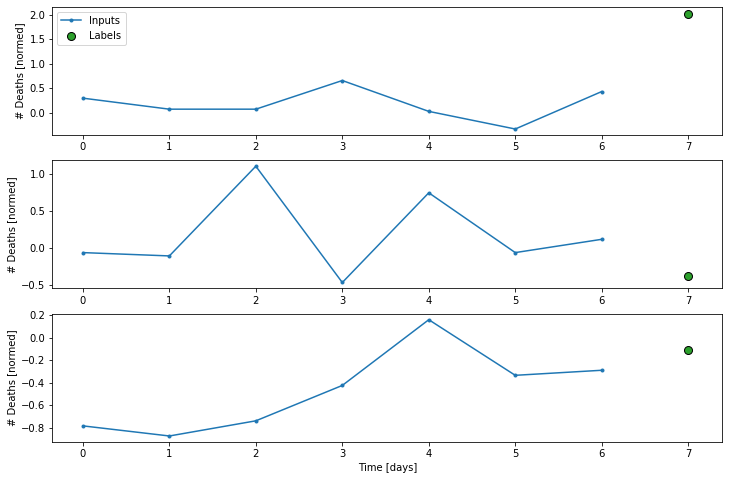

In [295]:
OUT_STEPS = 1
multi_window = WindowGenerator(input_width=7,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot(plot_col='# Deaths', max_subplots=3)
multi_window

#### 7a) Multi-Step Baseline

2/2 [==============================] - 0s 2ms/step - loss: 0.4911 - mean_absolute_error: 0.3156


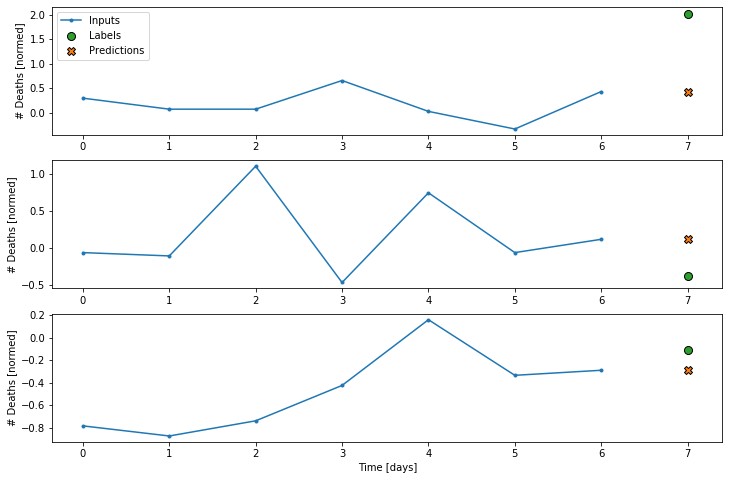

In [296]:
# One approach is to just use the last seen value repeatedly
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

2/2 [==============================] - 0s 5ms/step - loss: 0.4624 - mean_absolute_error: 0.3625


ValueError: x and y must be the same size

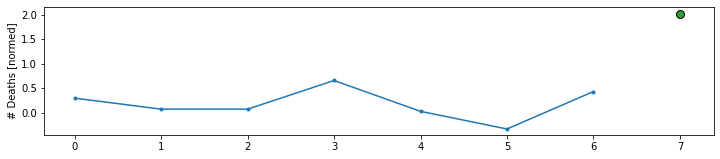

In [297]:
# Another baseline approach is to just repeat the pattern that you just saw
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

#### 7b) Single Shot Models

These models take the previous values, and use them to predict all of the output labels at once
without any autoregressive behaviour (i.e. adding the previous prediction as input to the make 
the next prediction)

(See the TensorFlow time series tutorial in the Advanced section at the bottom, for an implementation of this)

#### Linear Model

In [293]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance['Linear_multi'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear_multi'] = multi_linear_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
8/8 [==============================] - 1s 51ms/step - loss: 0.8917 - mean_absolute_error: 0.7435 - val_loss: 0.5654 - val_mean_absolute_error: 0.7376
Epoch 2/50
8/8 [==============================] - 0s 47ms/step - loss: 0.8984 - mean_absolute_error: 0.7471 - val_loss: 0.5537 - val_mean_absolute_error: 0.7296
Epoch 3/50
8/8 [==============================] - 0s 23ms/step - loss: 0.8714 - mean_absolute_error: 0.7053 - val_loss: 0.5435 - val_mean_absolute_error: 0.7226
Epoch 4/50
8/8 [==============================] - 1s 87ms/step - loss: 0.9921 - mean_absolute_error: 0.7250 - val_loss: 0.5329 - val_mean_absolute_error: 0.7150
Epoch 5/50
8/8 [==============================] - 0s 25ms/step - loss: 0.7212 - mean_absolute_error: 0.6767 - val_loss: 0.5224 - val_mean_absolute_error: 0.7075
Epoch 6/50
8/8 [==============================] - 0s 40ms/step - loss: 0.6694 - mean_absolute_error: 0.6432 - val_loss: 0.5104 - val_mean_absolute_error: 0.6986
Epoch 7/50
8/8 [==================

8/8 [==============================] - 0s 34ms/step - loss: 0.3389 - mean_absolute_error: 0.3583 - val_loss: 0.1184 - val_mean_absolute_error: 0.3072
Epoch 47/50
8/8 [==============================] - 0s 32ms/step - loss: 0.2320 - mean_absolute_error: 0.3027 - val_loss: 0.1136 - val_mean_absolute_error: 0.3006
Epoch 48/50
8/8 [==============================] - 0s 22ms/step - loss: 0.2216 - mean_absolute_error: 0.3152 - val_loss: 0.1075 - val_mean_absolute_error: 0.2918
Epoch 49/50
8/8 [==============================] - 0s 30ms/step - loss: 0.4880 - mean_absolute_error: 0.3844 - val_loss: 0.1029 - val_mean_absolute_error: 0.2851
Epoch 50/50
2/2 [==============================] - 0s 11ms/step - loss: 0.0988 - mean_absolute_error: 0.2789


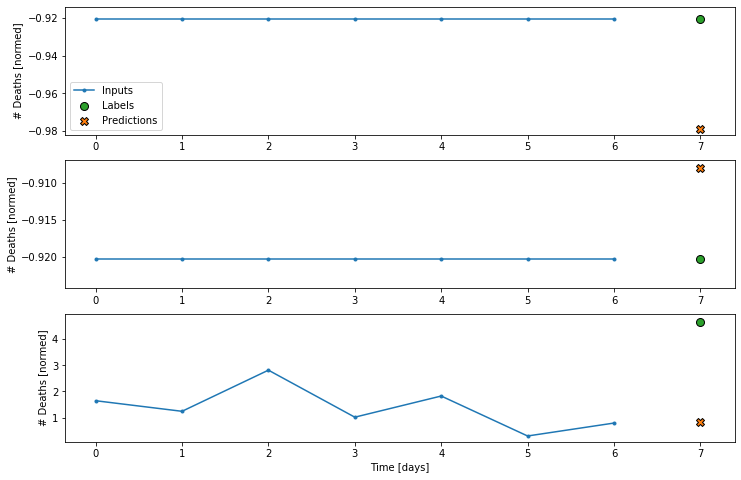

In [294]:
multi_window.plot(multi_linear_model)

#### Dense Model

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

multi_val_performance['Dense_multi'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense_multi'] = multi_dense_model.evaluate(multi_window.test, verbose=0)

In [ ]:
multi_window.plot(multi_dense_model)

#### LSTM Model

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 7 days, before making a single prediction for the next 7 days.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set return_sequences=False.

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['LSTM_multi'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM_multi'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

In [ ]:
multi_window.plot(multi_lstm_model, plot_col='# Deaths')

In [ ]:
labels = ['# Confirmed_Cases', '# Deaths', '# Recovered']

# Specifying the features
# features = ['# Tested', 'TotalHospitalized', 'TotalICU', 
#        'DailyHospitalized', 'DailyICU', 
#        'Population', 'Day_of_Year', 'Day_of_Week', 
#        'Province_BC', 'Province_Manitoba', 'Province_NL',
#        'Province_NWT', 'Province_New Brunswick', 'Province_Nova Scotia',
#        'Province_Nunavut', 'Province_Ontario', 'Province_PEI',
#        'Province_Quebec', 'Province_Saskatchewan', 'Province_Yukon']

features = ['Province_BC', 'Province_Manitoba', 'Province_NL',
       'Province_NWT', 'Province_New Brunswick', 'Province_Nova Scotia',
       'Province_Nunavut', 'Province_Ontario', 'Province_PEI',
       'Province_Quebec', 'Province_Saskatchewan', 'Province_Yukon']

# specify the number of lag days
n_days = 10